In [1]:
%matplotlib inline
from IPython.display import display, display_markdown
import subprocess as sp

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import bambi
import copy
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 300

sns.set_style('whitegrid')
sns.set_palette('Set2')

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'python3 -m jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

# Loading data
## Original study

In [2]:
df = pd.read_csv('illusions.tsv', sep='\t').drop(columns=['Unnamed: 0']).rename(columns={
    'IllusionType': 'illusion_type',
    'ACC': 'accuracy',
    'Condition': 'illusion_condition',
    'Trialnumber': 'trial',
})
labels = pd.read_csv('illusion_labels.tsv', sep='\t')
df = df.merge(labels, how='left', on='trial')
dfr = pd.read_csv('tamil_reading.tsv', sep='\t')
df = df.merge(dfr, on=['pp', 'subject', 'literate'], how='left').dropna()
df = df[df['illusion_type'] != 'ambiguous']
df['experiment'] = 'original'
df['participant'] = df.apply(lambda x: x['experiment'] + '_' + str(x['number']) + '_' + x['literate'], axis=1)
df['literate'] = df['literate'].replace({
    'y': 'high-literate',
    'low': 'low-literate',
    'n': 'illiterate',
})
display(df.head().round(2))

,trial,illusion_type,illusion_condition,RT,accuracy,literate,number,key,pp,subject,illusion_name,word,pseudoword,experiment,participant
2,21,colour,illusion,12.12,1.0,low-literate,1,2,low_1,1,saturationcontrast,24.0,1.0,original,original_1_low
3,7,shape,illusion,6.29,0.0,low-literate,1,2,low_1,1,ehrenstein,24.0,1.0,original,original_1_low
4,11,shape,illusion,8.96,1.0,low-literate,1,minus,low_1,1,verticalhorizontal,24.0,1.0,original,original_1_low
5,9,shape,illusion,7.88,1.0,low-literate,1,minus,low_1,1,orbison,24.0,1.0,original,original_1_low
6,45,colour,control,9.98,1.0,low-literate,1,2,low_1,1,cornsweet,24.0,1.0,original,original_1_low


## Followup study

In [3]:
df_fu = pd.read_csv('illusions_followup.tsv', sep='\t').drop(columns=['Unnamed: 0']).rename(columns={
    'IllusionType': 'illusion_type',
    'ACC': 'accuracy',
    'Condition': 'illusion_condition',
    'Trialnumber': 'trial',
})
df_fu = df_fu.merge(labels, how='left', on='trial')
dfr_fu = pd.read_csv('followup_tamil_reading.tsv', sep='\t')
df_fu = df_fu.merge(dfr_fu, on=['pp', 'literate'], how='left').dropna()
df_fu = df_fu[df_fu['illusion_type'] != 'ambiguous']
df_fu['experiment'] = 'followup'
df_fu['participant'] = df_fu.apply(lambda x: x['experiment'] + '_' + str(x['number']) + '_' + x['literate'], axis=1)
df_fu['literate'] = df_fu['literate'].replace({
    'y': 'high-literate',
    'low': 'low-literate',
    'n': 'illiterate',
})
display(df_fu.head().round(2))

,trial,illusion_type,illusion_condition,RT,accuracy,literate,number,key,pp,subject,illusion_name,word,pseudoword,experiment,participant
47,21,colour,illusion,6.64,1.0,illiterate,1,2,n_1,2,saturationcontrast,0.0,0.0,followup,followup_1_n
48,7,shape,illusion,6.60,1.0,illiterate,1,2,n_1,2,ehrenstein,0.0,0.0,followup,followup_1_n
49,11,shape,illusion,8.35,0.0,illiterate,1,minus,n_1,2,verticalhorizontal,0.0,0.0,followup,followup_1_n
50,9,shape,illusion,7.05,0.0,illiterate,1,minus,n_1,2,orbison,0.0,0.0,followup,followup_1_n
51,45,colour,control,6.00,1.0,illiterate,1,2,n_1,2,cornsweet,0.0,0.0,followup,followup_1_n


## Join data

In [4]:
df_pooled = pd.concat([df, df_fu])
df_pooled['log_rt'] = np.log(df_pooled['RT'])
display(df_pooled.head().round(2))

,trial,illusion_type,illusion_condition,RT,accuracy,literate,number,key,pp,subject,illusion_name,word,pseudoword,experiment,participant,log_rt
2,21,colour,illusion,12.12,1.0,low-literate,1,2,low_1,1,saturationcontrast,24.0,1.0,original,original_1_low,2.50
3,7,shape,illusion,6.29,0.0,low-literate,1,2,low_1,1,ehrenstein,24.0,1.0,original,original_1_low,1.84
4,11,shape,illusion,8.96,1.0,low-literate,1,minus,low_1,1,verticalhorizontal,24.0,1.0,original,original_1_low,2.19
5,9,shape,illusion,7.88,1.0,low-literate,1,minus,low_1,1,orbison,24.0,1.0,original,original_1_low,2.06
6,45,colour,control,9.98,1.0,low-literate,1,2,low_1,1,cornsweet,24.0,1.0,original,original_1_low,2.30


## Correct mislabeled trials
Labels for the illusion and control trials of the cornsweet illusion were accidentally switched during the making of the stimuli. The trials were presented with the correct prompts, so rather than discarding them, we can simply switch the labels back. Note that since this only affects the labels for one illusion, switching the labels doesn't much affect the outcome of the statistical analysis one way or the other.

In [5]:
df_pooled.loc[df_pooled['illusion_name'] == 'cornsweet', 'illusion_condition'] = df_pooled.loc[df_pooled['illusion_name'] == 'cornsweet', 'illusion_condition'].replace(
    {'illusion': 'control', 'control': 'illusion'})

In [19]:
#df_pooled = df_pooled[df_pooled['illusion_name'] != 'oppelkundt']
#df_pooled = df_pooled[df_pooled['illusion_name'] != 'poggendoff']
#df_pooled = df_pooled[df_pooled['illusion_name'] != 'verticalhorizontal']
unique_ilsn = df_pooled.loc[df_pooled['illusion_condition'] == 'illusion', 'illusion_name'].unique()
unique_ilsn_shape = df_pooled.loc[(df_pooled['illusion_condition'] == 'illusion') & (df_pooled['illusion_type'] == 'colour'), 'illusion_name'].unique()
unique_ctrl_shape = df_pooled.loc[(df_pooled['illusion_condition'] == 'control') & (df_pooled['illusion_type'] == 'colour'), 'illusion_name'].unique()
unique_ctrl = df_pooled.loc[df_pooled['illusion_condition'] == 'control', 'illusion_name'].unique()
print(len(unique_ilsn))
print(len(unique_ctrl))
print(len(unique_ilsn_shape))
print(len(unique_ctrl_shape))
print(sorted(unique_ilsn))
print(sorted(unique_ctrl))

22
19
6
6
['amodal', 'bourdon', 'checkerboard', 'cornsweet', 'cyansquare', 'delboeuf', 'ebbinghaus', 'ehrenstein', 'giovanelli', 'hering', 'jastrow', 'mullerlyer', 'oppelkundt', 'orbison', 'poggendoff', 'ponzo', 'sanders', 'saturationcontrast', 'shepardtable', 'verticalhorizontal', 'white', 'whitedottedline']
['amodal', 'bourdon', 'checkerboard', 'cornsweet', 'cyansquare', 'delboeuf', 'ebbinghaus', 'ehrenstein', 'giovanelli', 'hering', 'jastrow', 'mullerlyer', 'orbison', 'ponzo', 'sanders', 'saturationcontrast', 'shepardtable', 'white', 'whitedottedline']


# Plot raw data
For a quick visual exploration of the data, we plot it as bar graphs. The first study contained three groups: 'y' (high-literate), 'low' (low-literate), and 'n' (illiterate).

The followup study did not include a low-literate group, and therefore only the 'y' (high-literate) and 'n' (illiterate) groups are plotted.

## Accuracy

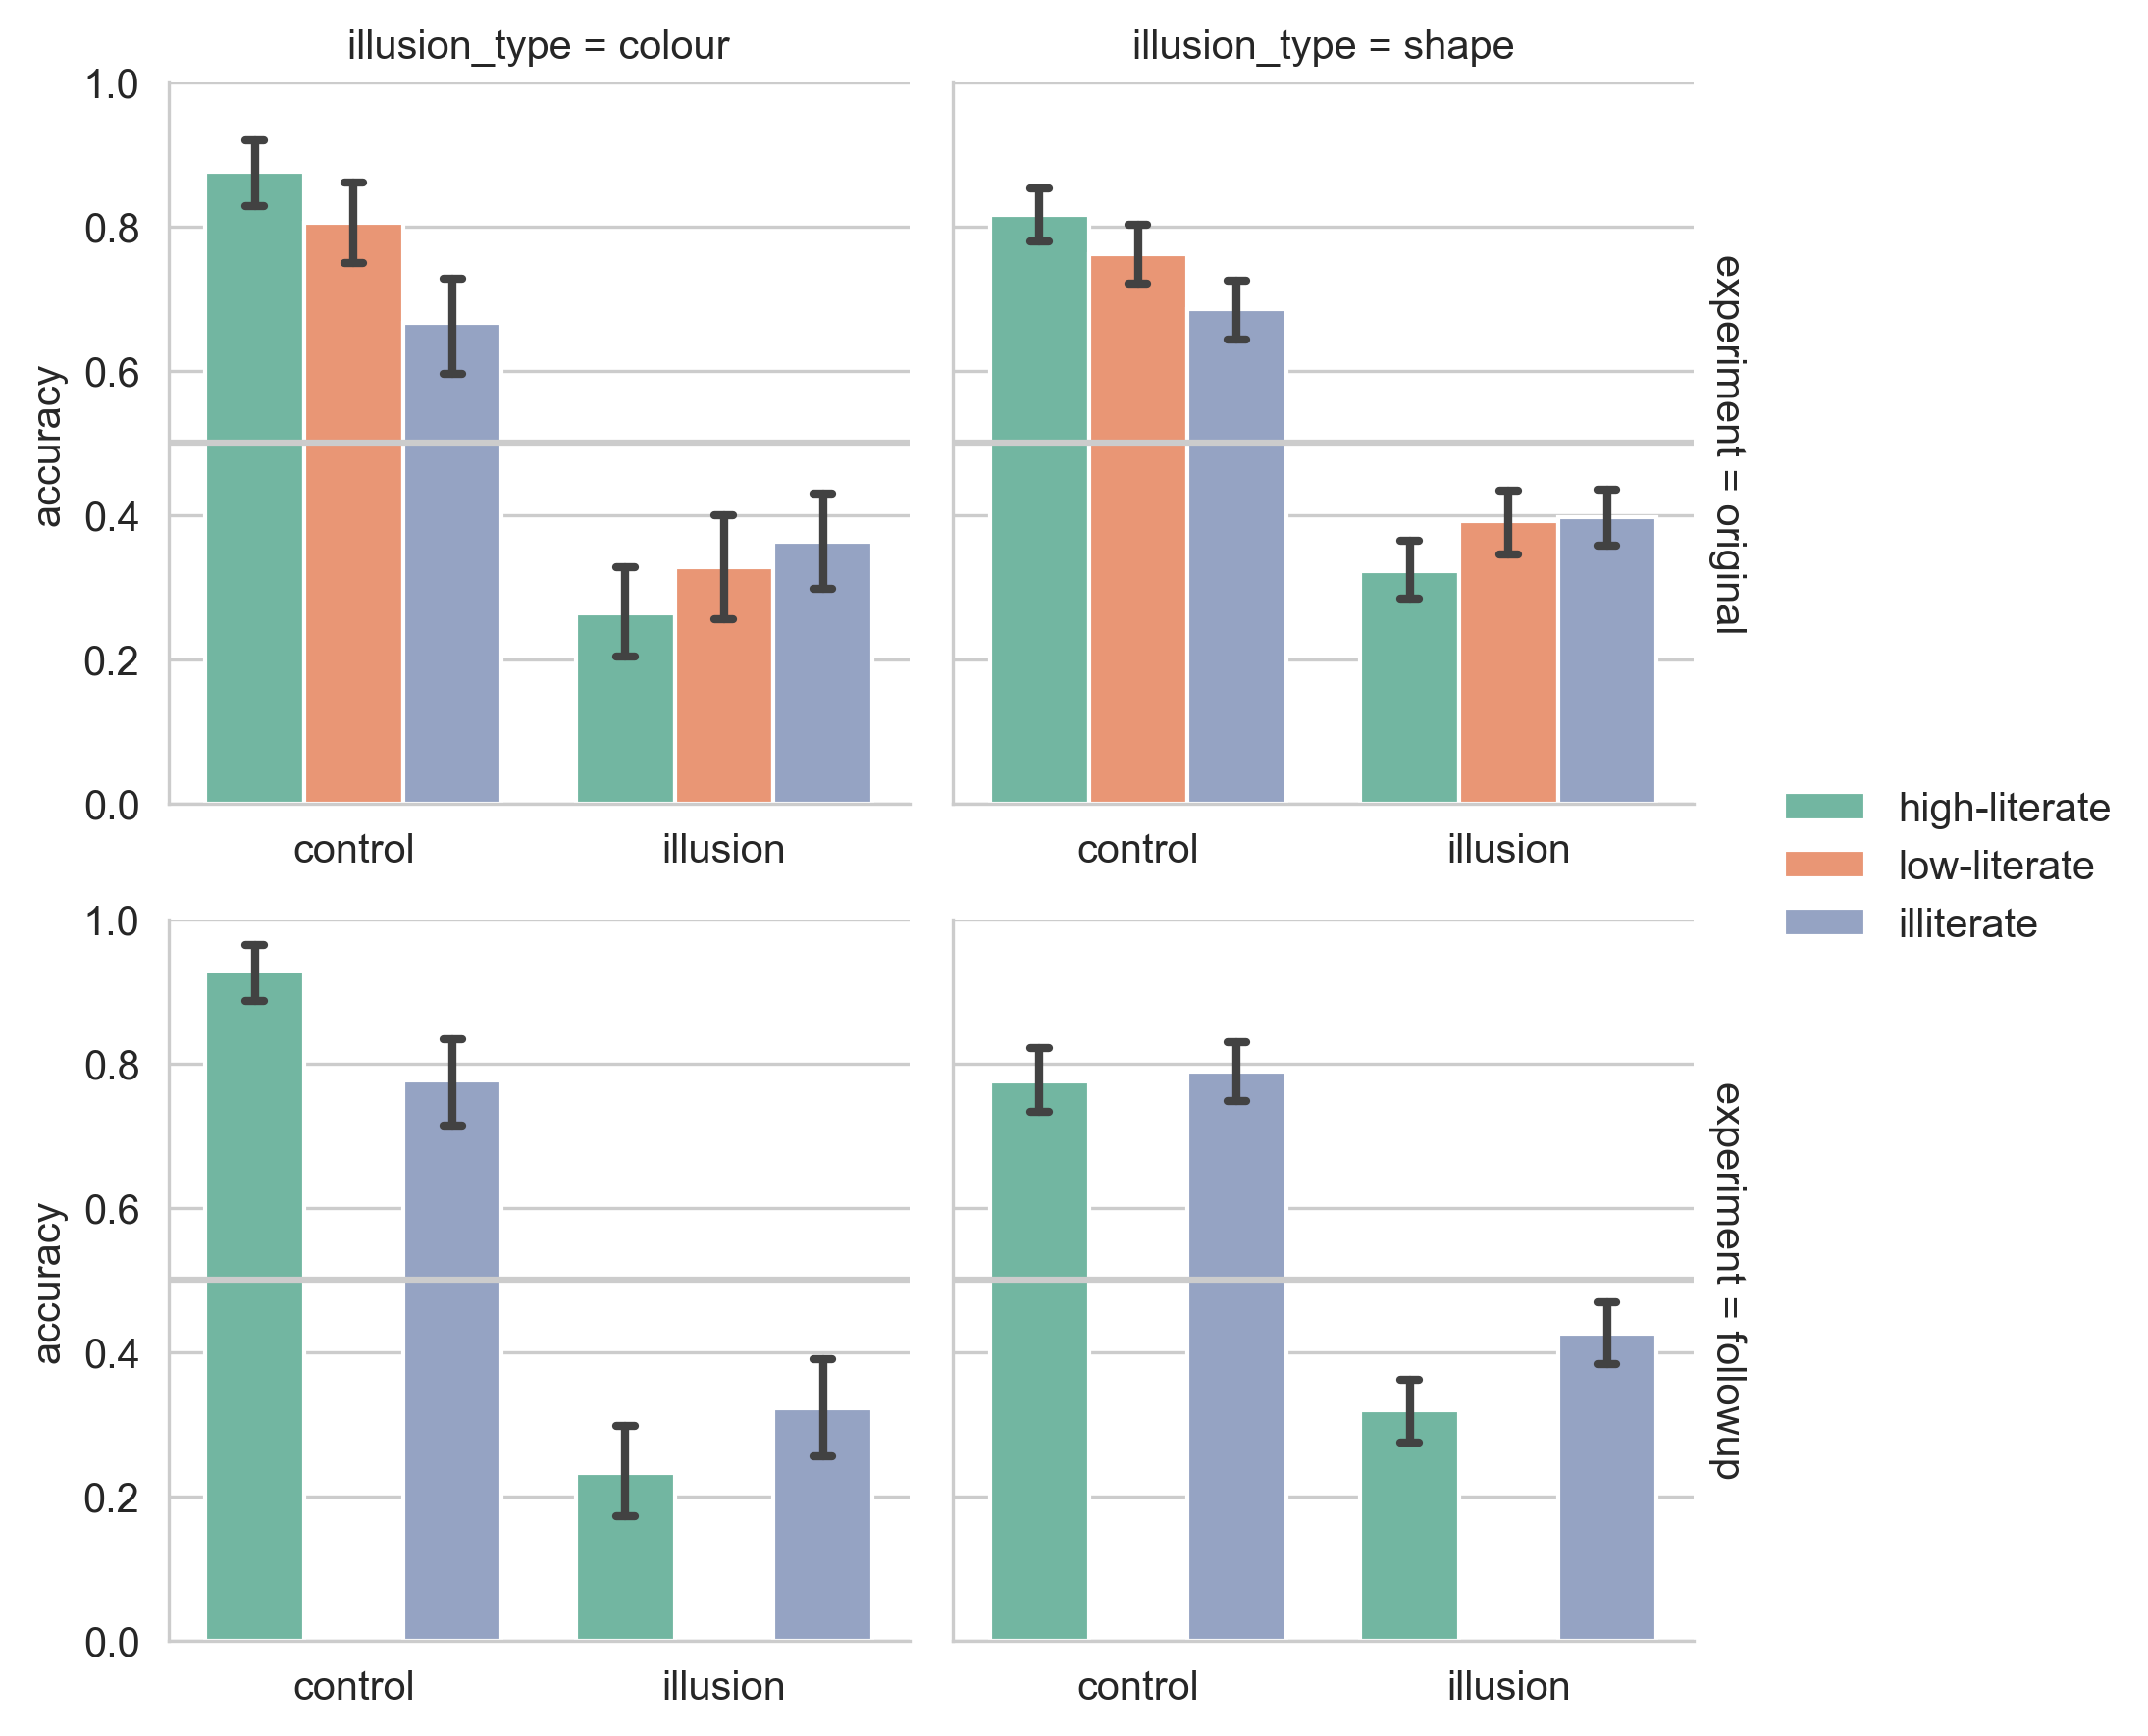

In [7]:
g = sns.catplot(
    x='illusion_condition',
    y='accuracy',
    hue='literate',
    hue_order=['high-literate', 'low-literate', 'illiterate'],
    col='illusion_type',
    row='experiment',
    row_order=['original', 'followup'],
    data=df_pooled.sort_values(['illusion_condition', 'illusion_type']),
    kind='bar',
    height=3,
    capsize=.05,
    errwidth=2,
    margin_titles=True,
    sharex=False,
)
g.axes[0][0].axhline(.5, color='.8')
g.axes[0][1].axhline(.5, color='.8')
g.axes[1][0].axhline(.5, color='.8')
g.axes[1][1].axhline(.5, color='.8')
g.legend.set_title('')
g.set(xlabel='', ylim=[0, 1])
plt.savefig('figures/raw_accuracy_barplot.pdf')

## Response time

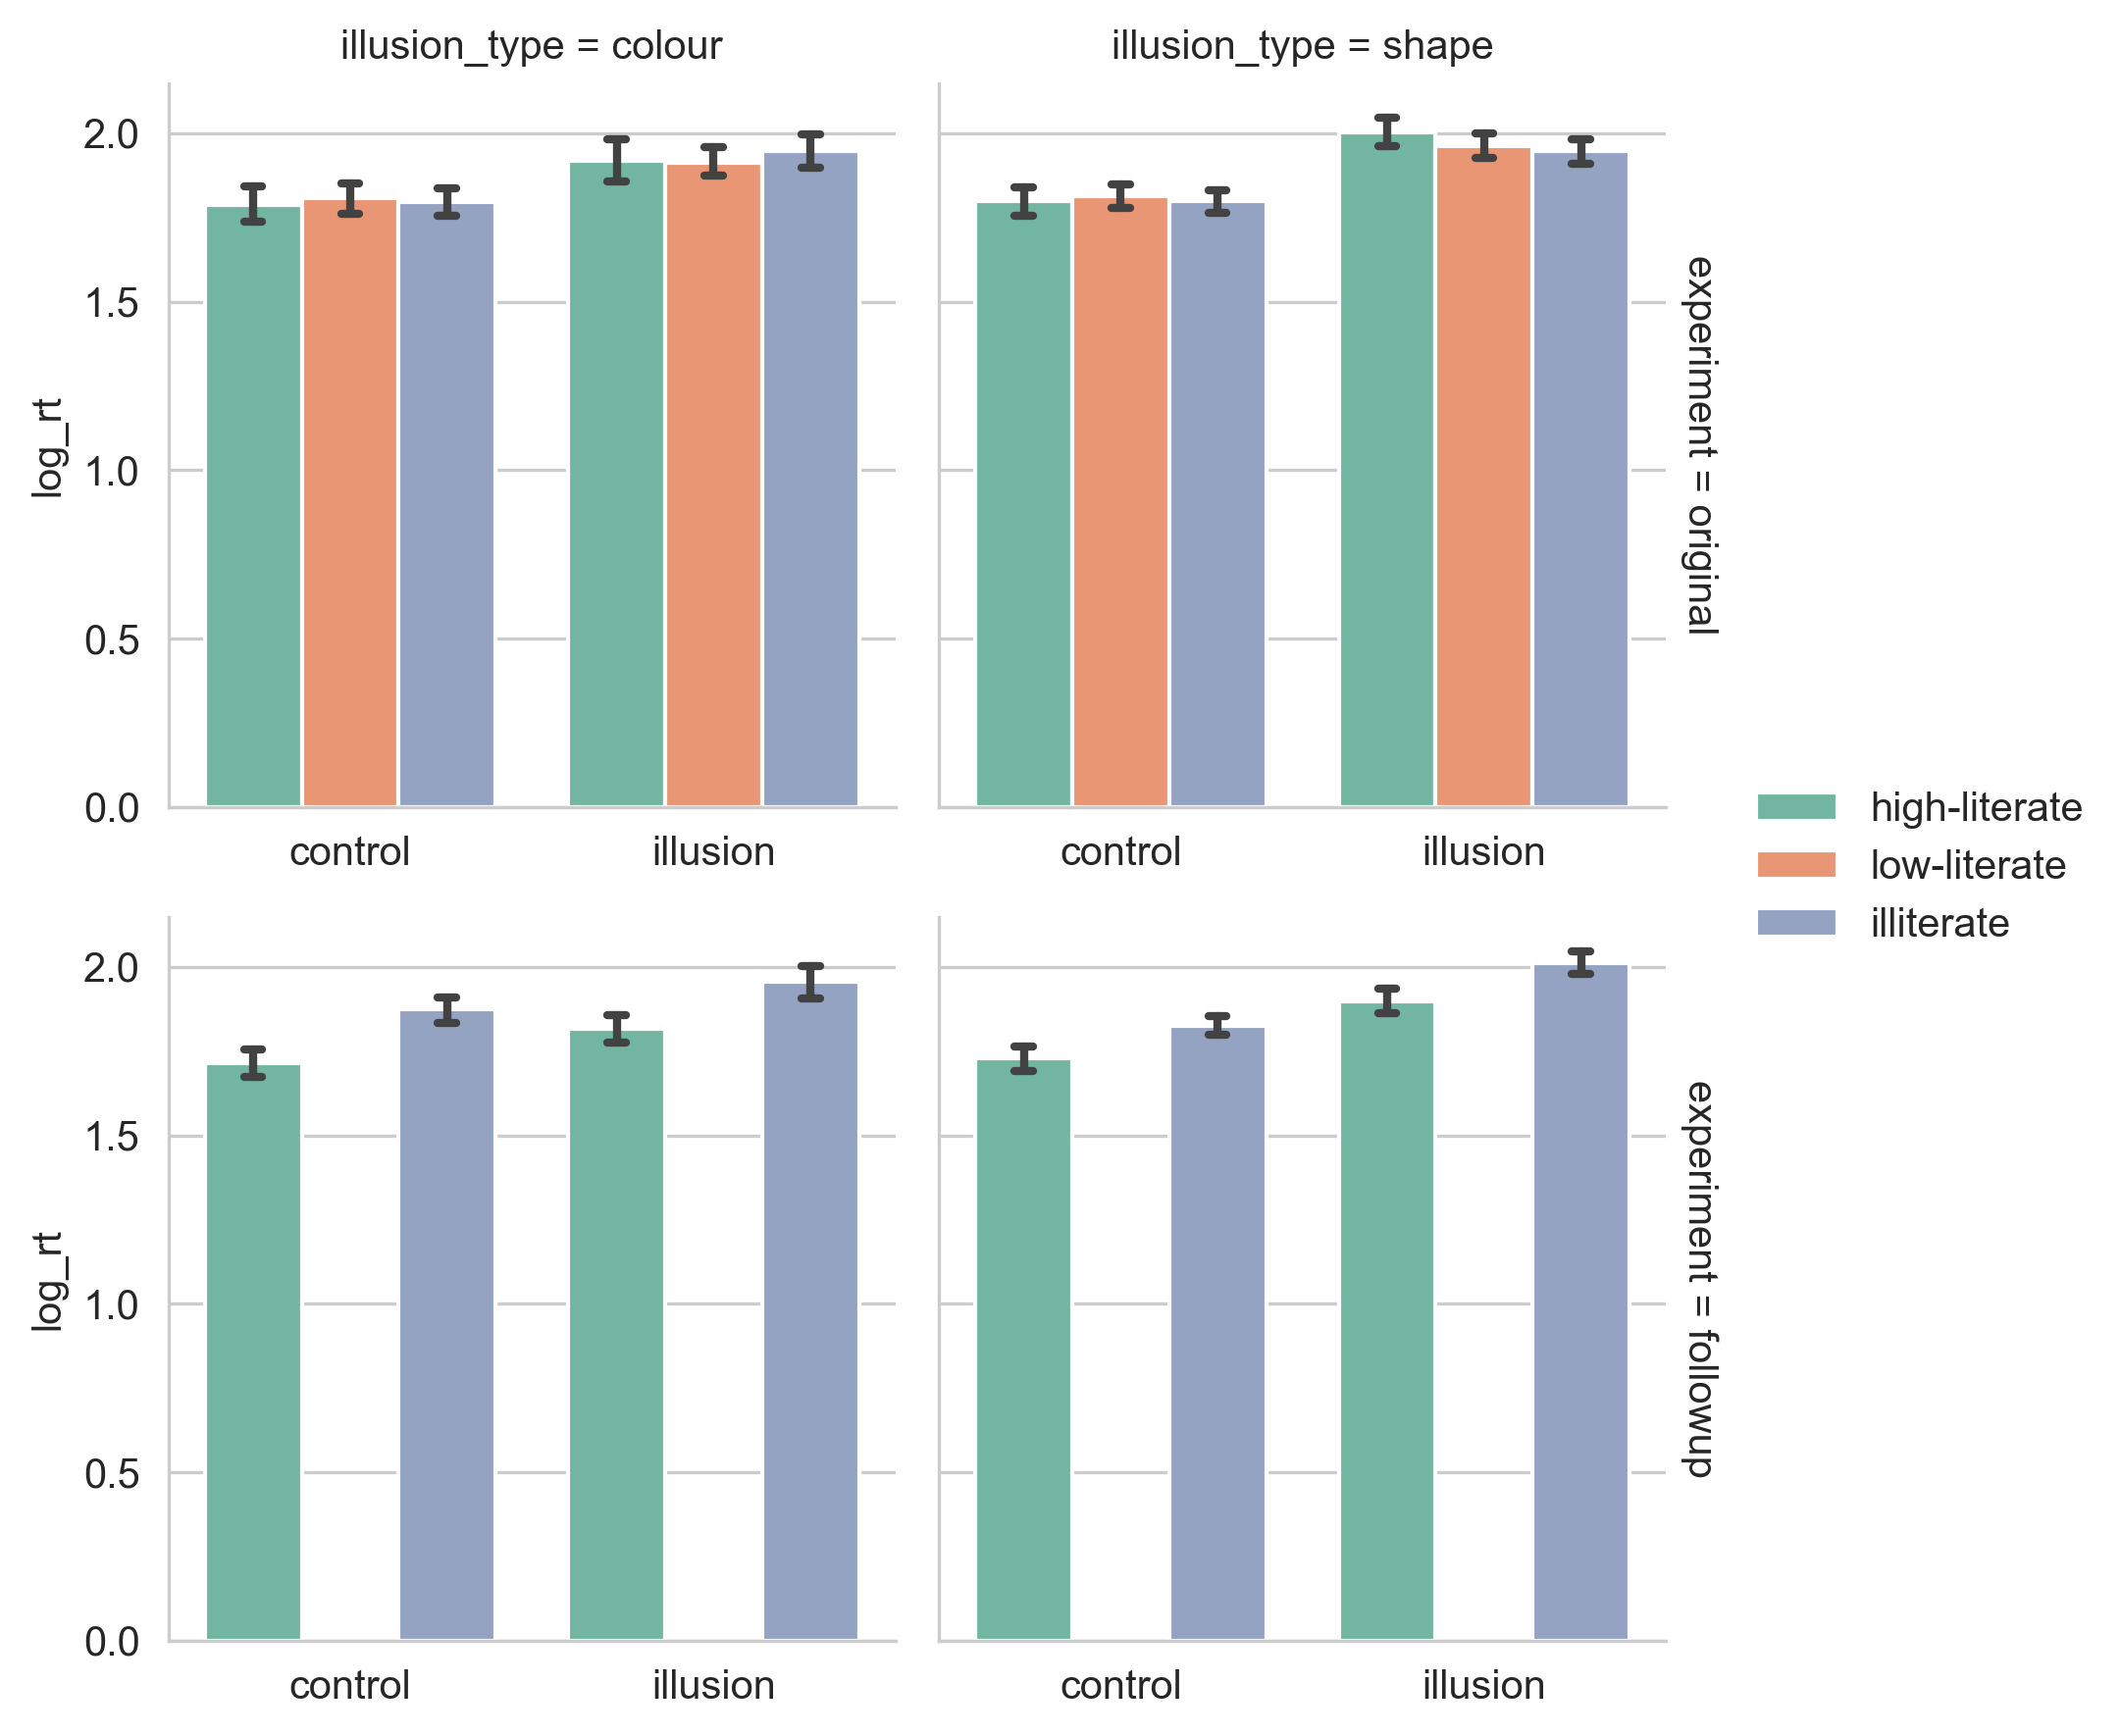

In [8]:
g = sns.catplot(
    x='illusion_condition',
    y='log_rt',
    hue='literate',
    hue_order=['high-literate', 'low-literate', 'illiterate'],
    col='illusion_type',
    row='experiment',
    row_order=['original', 'followup'],
    data=df_pooled.sort_values(['illusion_condition', 'illusion_type']),
    kind='bar',
    height=3,
    capsize=.05,
    errwidth=2,
    margin_titles=True,
    sharex=False,
)
g.legend.set_title('')
g.set(xlabel='')
plt.savefig('figures/rt_barplot.pdf')

# Invert the illusion scores
The illusion scores are plotted in a way that is intuitively correct, but confusing from a modeling perspective: We count a response as correct on an illusion trial if the participant _does not_ perceive the illusion. This means however that what we consider to be the normal (as in _modal_ response in the population at large) response, which is to perceive the illusion, to be erroneous.  
This becomes problematic when we try to model participant responses, because we can clearly see in the figures above that illiterates are close to chance level performance on both illusion and control trials, but in a mixed-effects model this would not be reflected in the coefficient estimates.  
The solution is simple: We invert the responses in the illusion condition, to make perceiving the illusion the "correct" response. Now the trend towards chance level performance for the illiterates lines up in both illusion and control conditions.

In [9]:
df_pooled['accuracy_rectified'] = df_pooled.apply(
    lambda x: 1 - x['accuracy'] if x['illusion_condition'] == 'illusion' else x['accuracy'], axis=1
)
display(df_pooled.head().round(2))

,trial,illusion_type,illusion_condition,RT,accuracy,literate,number,key,pp,subject,illusion_name,word,pseudoword,experiment,participant,log_rt,accuracy_rectified
2,21,colour,illusion,12.12,1.0,low-literate,1,2,low_1,1,saturationcontrast,24.0,1.0,original,original_1_low,2.50,0.0
3,7,shape,illusion,6.29,0.0,low-literate,1,2,low_1,1,ehrenstein,24.0,1.0,original,original_1_low,1.84,1.0
4,11,shape,illusion,8.96,1.0,low-literate,1,minus,low_1,1,verticalhorizontal,24.0,1.0,original,original_1_low,2.19,0.0
5,9,shape,illusion,7.88,1.0,low-literate,1,minus,low_1,1,orbison,24.0,1.0,original,original_1_low,2.06,0.0
6,45,colour,illusion,9.98,1.0,low-literate,1,2,low_1,1,cornsweet,24.0,1.0,original,original_1_low,2.30,0.0


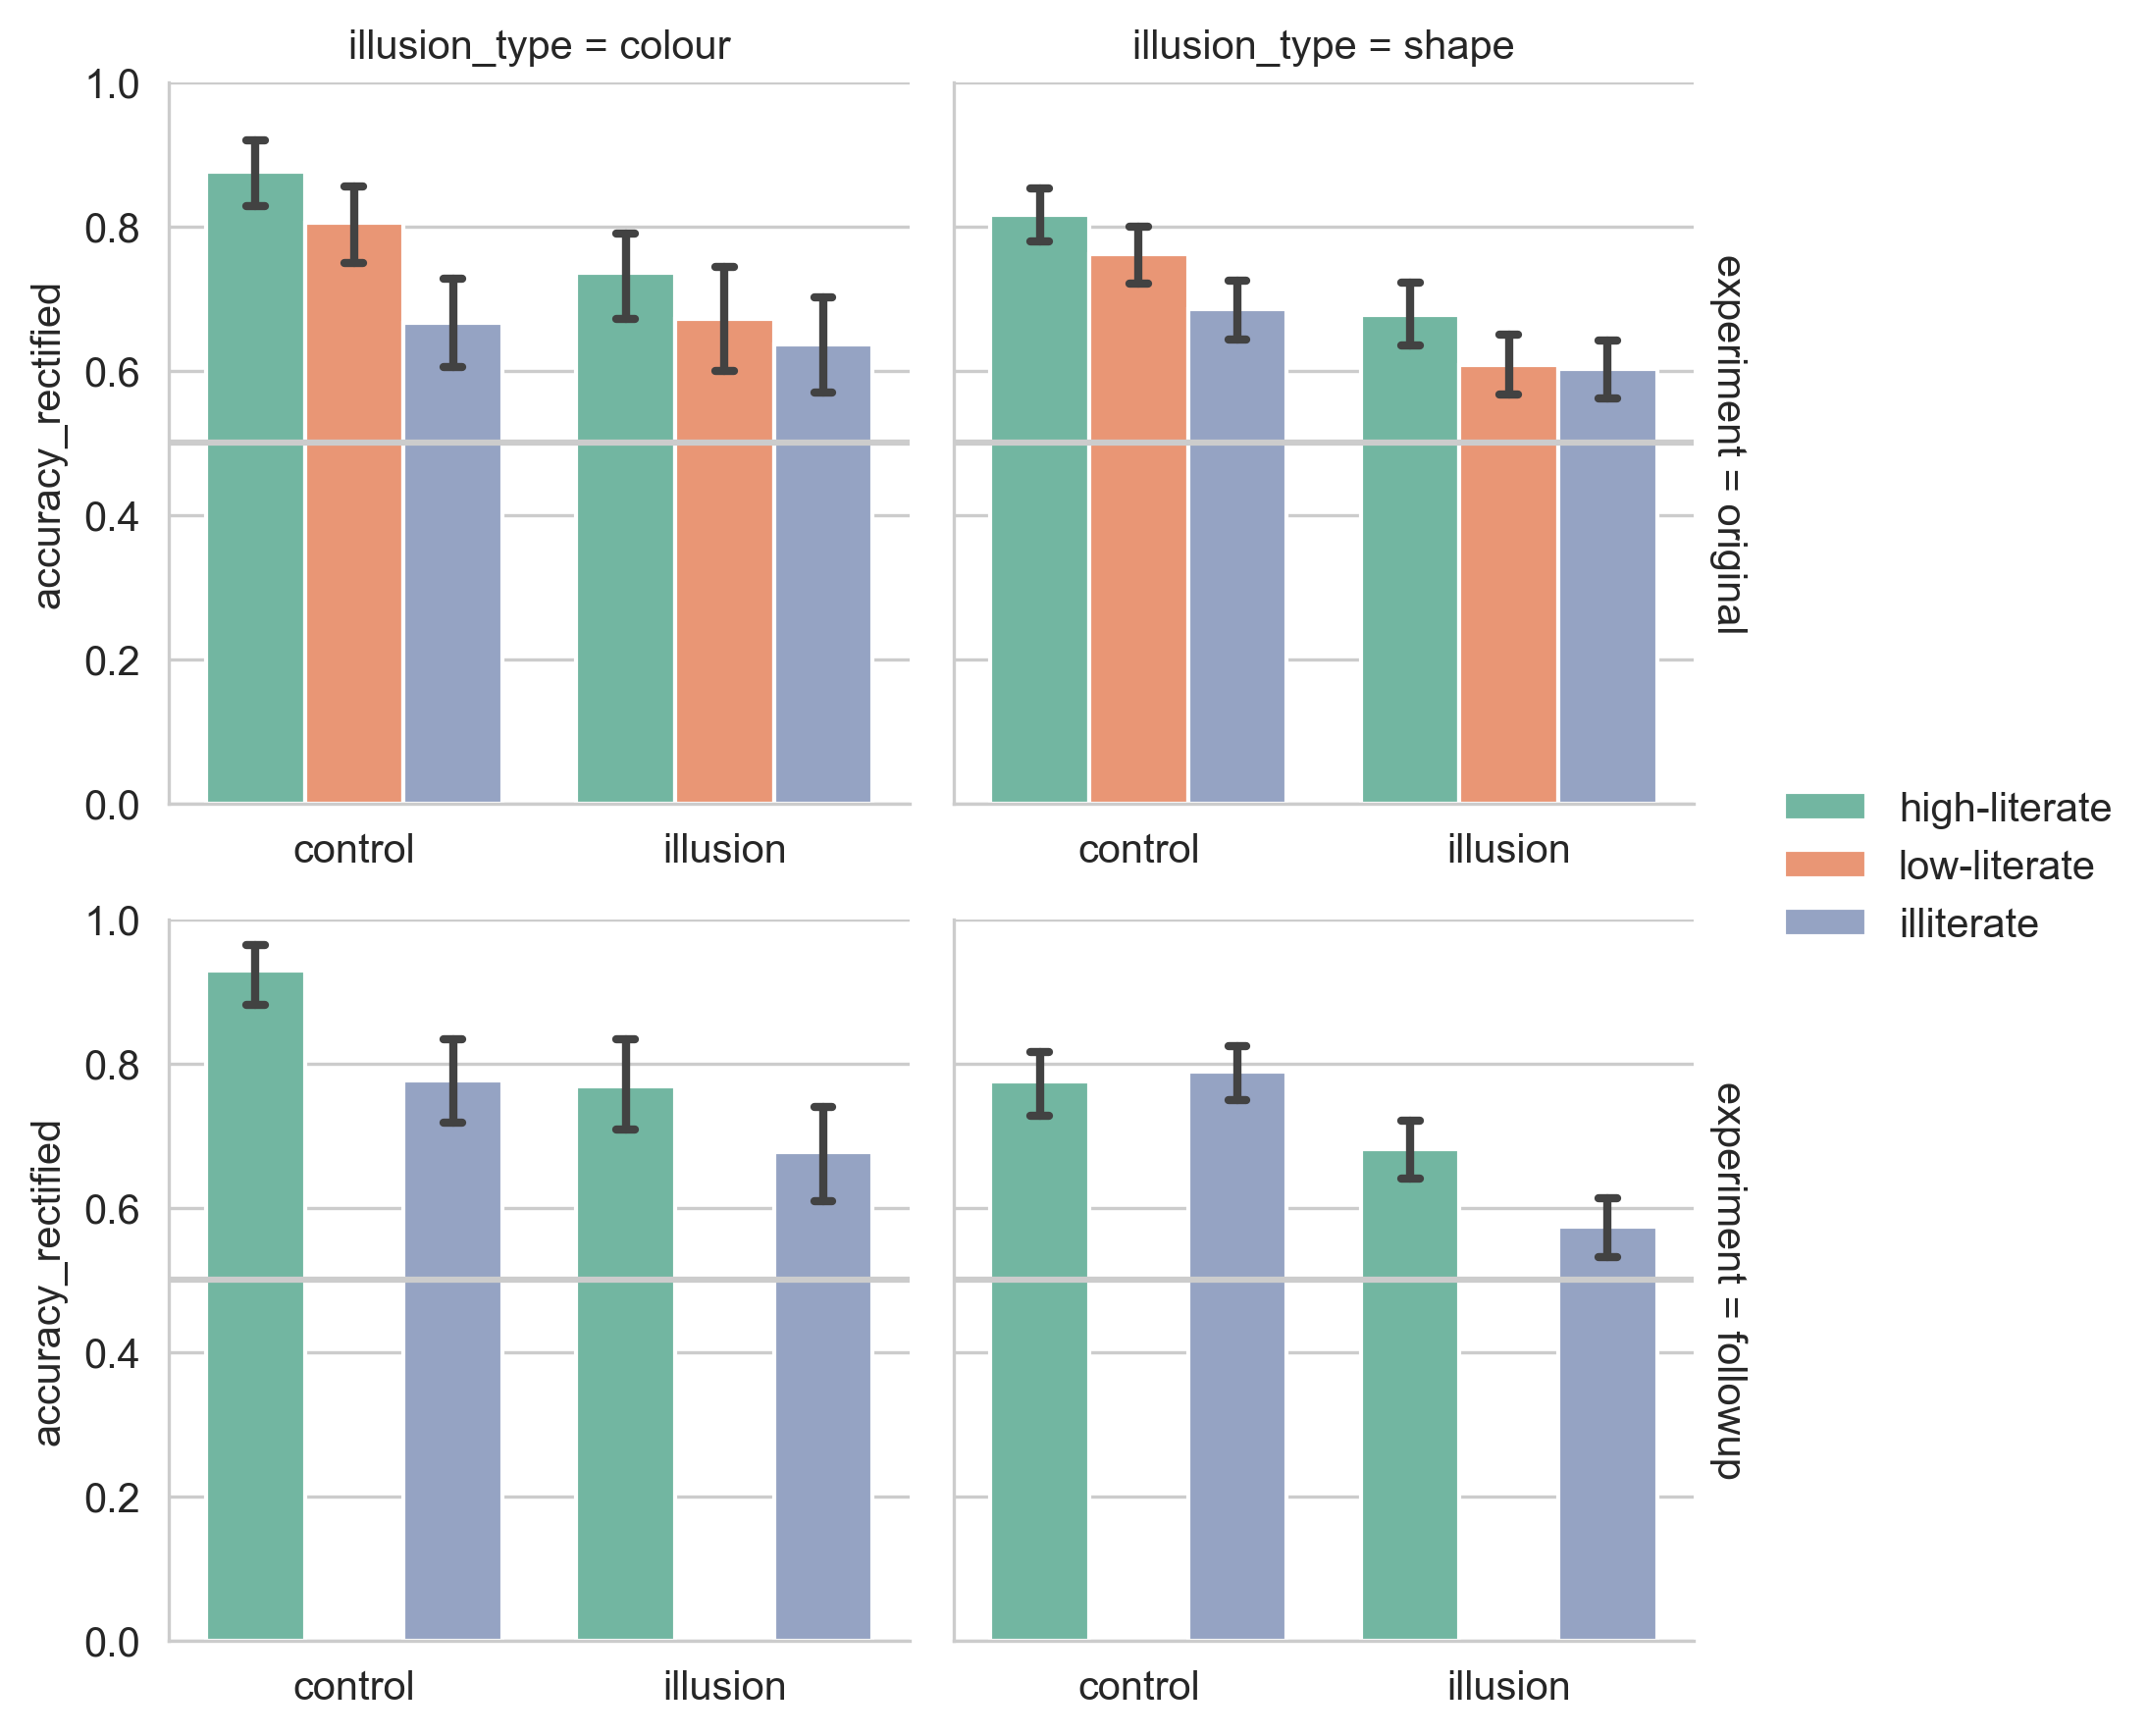

In [10]:
g = sns.catplot(
    x='illusion_condition',
    y='accuracy_rectified',
    hue='literate',
    hue_order=['high-literate', 'low-literate', 'illiterate'],
    col='illusion_type',
    row='experiment',
    row_order=['original', 'followup'],
    data=df_pooled.sort_values(['illusion_condition', 'illusion_type']),
    kind='bar',
    height=3,
    capsize=.05,
    errwidth=2,
    margin_titles=True,
    sharex=False,
)
g.axes[0][0].axhline(.5, color='.8')
g.axes[0][1].axhline(.5, color='.8')
g.axes[1][0].axhline(.5, color='.8')
g.axes[1][1].axhline(.5, color='.8')
g.legend.set_title('')
g.set(xlabel='', ylim=[0, 1])
plt.savefig('figures/rectified_accuracy_barplot.pdf')

# Analysis of original study

## Creating some centered and standardized predictors

In [11]:
df = copy.deepcopy(df_pooled[df_pooled['experiment'] == 'original'])

df['reading'] = df['word'] + df['pseudoword']
df['literate_binary'] = df['literate'].apply(lambda x: 1 if x != 'n' else 0)
df['illusion'] = df['illusion_condition'].apply(lambda x: 1 if x == 'illusion' else 0)
df['shape'] = df['illusion_type'].apply(lambda x: 1 if x == 'shape' else 0)

df['reading_z'] = (df['reading'] - df['reading'].mean()) / df['reading'].std()
df['illusion_condition_z'] = df['illusion'] - .5
df['illusion_type_z'] = df['shape'] - .5

df['log_rt'] = np.log(df['RT'])
df['log_rt_z'] = (df['log_rt'] - df['log_rt'].mean()) / df['log_rt'].std()

display(df.head().round(2))

,trial,illusion_type,illusion_condition,RT,accuracy,literate,number,key,pp,subject,...,log_rt,accuracy_rectified,reading,literate_binary,illusion,shape,reading_z,illusion_condition_z,illusion_type_z,log_rt_z
2,21,colour,illusion,12.12,1.0,low-literate,1,2,low_1,1,...,2.50,0.0,25.0,1,1,0,-0.62,0.5,-0.5,1.52
3,7,shape,illusion,6.29,0.0,low-literate,1,2,low_1,1,...,1.84,1.0,25.0,1,1,1,-0.62,0.5,0.5,-0.11
4,11,shape,illusion,8.96,1.0,low-literate,1,minus,low_1,1,...,2.19,0.0,25.0,1,1,1,-0.62,0.5,0.5,0.77
5,9,shape,illusion,7.88,1.0,low-literate,1,minus,low_1,1,...,2.06,0.0,25.0,1,1,1,-0.62,0.5,0.5,0.45
6,45,colour,illusion,9.98,1.0,low-literate,1,2,low_1,1,...,2.30,0.0,25.0,1,1,0,-0.62,0.5,-0.5,1.04


## Bayesian generalized linear mixed-effects model (GLMM)

In [12]:
model = bambi.Model(df)
results = model.fit(
    'accuracy_rectified ~ illusion_condition_z * illusion_type_z * reading_z',
    group_specific=[
        '1 + illusion_condition_z * illusion_type_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='bernoulli',
    init='advi+adapt_diag',
    chains=3,
    draws=2000,
    tune=2000,
    target_accept=.9,
)

Modeling the probability that accuracy_rectified==1
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 2,466.8
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [reading_z:illusion_condition_z|illusion_name_offset, reading_z:illusion_condition_z|illusion_name_sigma, illusion_condition_z|illusion_name_offset, illusion_condition_z|illusion_name_sigma, reading_z|illusion_name_offset, reading_z|illusion_name_sigma, 1|illusion_name_offset, 1|illusion_name_sigma, illusion_condition_z:illusion_type_z|participant_offset, illusion_condition_z:illusion_type_z|participant_sigma, illusion_type_z|participant_offset, illusion_type_z|participant_sigma, illusion_condition_z|participant_offset, illusion_condition_z|participant_sigma, 1|participant_offset, 1|participant_sigma, illusion_condition_z:illusion_type_z:reading_z, illusion_type_z:reading_z, illusion_condition_z:reading_z, reading_z, illusion_condition_z:illusion_type_z, illusion_type_z, illusion_condition_z, Intercept]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 232 seconds.
The number of effective samples is smaller than 25% for some parameters.


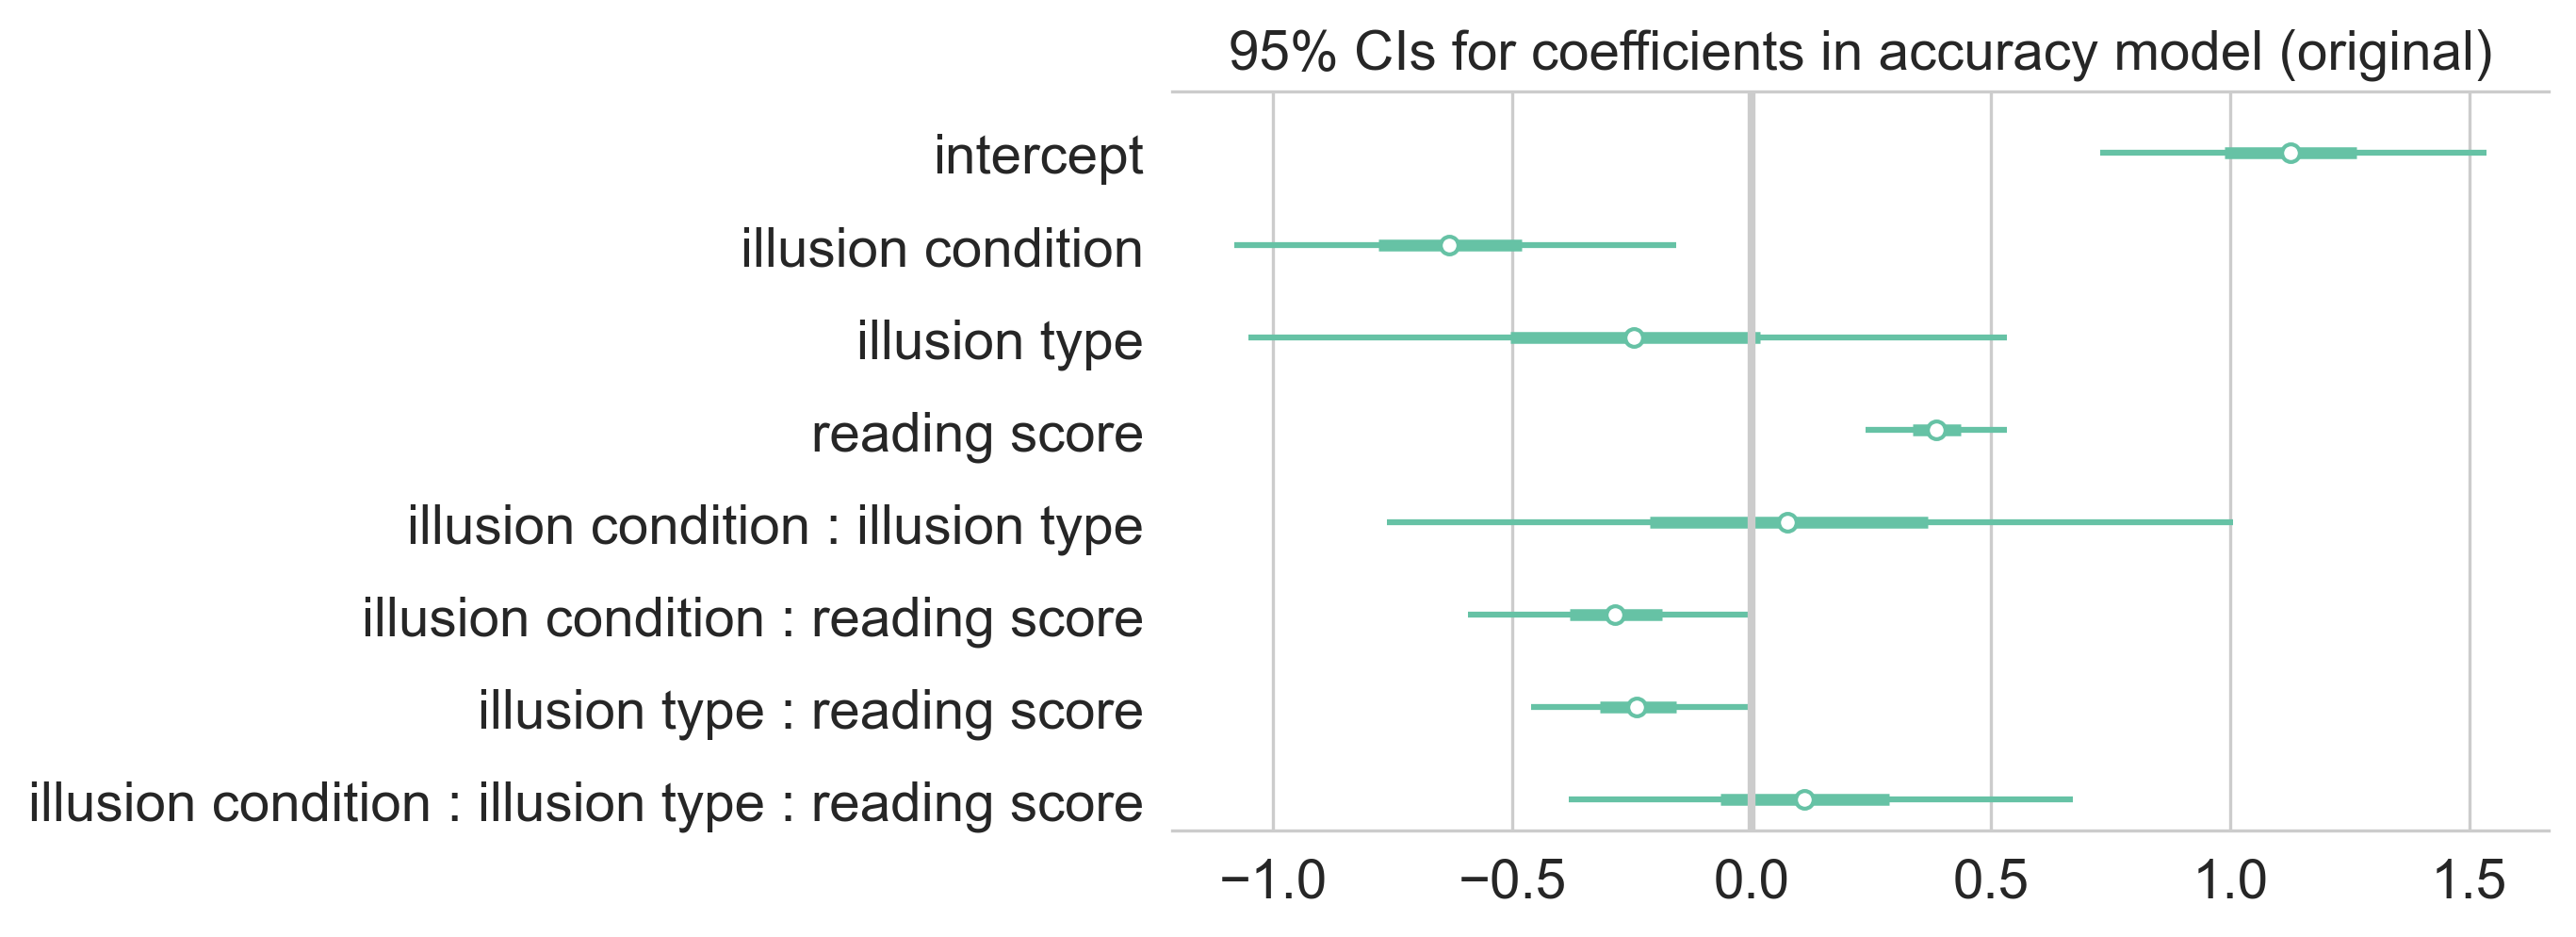

In [13]:
g = az.plot_forest(results, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'illusion_type_z',
                      'reading_z',
                      'illusion_condition_z:illusion_type_z',
                      'illusion_condition_z:reading_z',
                      'illusion_type_z:reading_z',
                      'illusion_condition_z:illusion_type_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'illusion type',
    'reading score',
    'illusion condition : illusion type',
    'illusion condition : reading score',
    'illusion type : reading score',
    'illusion condition : illusion type : reading score'
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in accuracy model (original)', fontsize=14);
plt.savefig('figures/accuracy_forestplot_original.pdf')

### Response time model

In [14]:
model_rt = bambi.Model(df)
results_rt = model_rt.fit(
    'log_rt_z ~ illusion_condition_z * illusion_type_z * reading_z',
    group_specific=[
        '1 + illusion_condition_z * illusion_type_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='gaussian',
    init='advi+adapt_diag',
    chains=3,
    draws=2000,
    tune=2000,
    target_accept=.9,
)

The random argument has been deprecated, please use group_specific
samples will be deprecated, please use draws instead
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 25400
Interrupted at 25,399 [50%]: Average Loss = 6,486.3
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [log_rt_z_sigma, reading_z:illusion_condition_z|illusion_name_offset, reading_z:illusion_condition_z|illusion_name_sigma, illusion_condition_z|illusion_name_offset, illusion_condition_z|illusion_name_sigma, reading_z|illusion_name_offset, reading_z|illusion_name_sigma, 1|illusion_name_offset, 1|illusion_name_sigma, illusion_condition_z:illusion_type_z|participant_offset, illusion_condition_z:illusion_type_z|participant_sigma, illusion_type_z|participant_offset, illusion_type_z|participant_sigma, illusion_condition_z|participant_offset, illusion_condition_z|participant_sigma, 1|participant_offset, 1|participant_sigma, illusion_condition_z:illusion_type_z:reading_z, illusion_type_z:reading_z, illusion_condition_z:reading_z, reading_z, illusion_condition_z:illusion_type_z, illusion_type_z, illusion_condition_z, Intercept]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 418 seconds.


KeyboardInterrupt: 

In [ ]:
g = az.plot_forest(results_rt, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'illusion_type_z',
                      'reading_z',
                      'illusion_condition_z:illusion_type_z',
                      'illusion_condition_z:reading_z',
                      'illusion_type_z:reading_z',
                      'illusion_condition_z:illusion_type_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'illusion type',
    'reading score',
    'illusion condition : illusion type',
    'illusion condition : reading score',
    'illusion type : reading score',
    'illusion condition : illusion type : reading score'
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in log(RT) model (original)', fontsize=14);
plt.savefig('figures/rt_forestplot_original.pdf')

# Analysis of followup study

## Creating some centered and standardized predictors

In [ ]:
df = copy.deepcopy(df_pooled[df_pooled['experiment'] == 'followup'])

df['reading'] = df['word'] + df['pseudoword']
df['literate_binary'] = df['literate'].apply(lambda x: 1 if x != 'n' else 0)
df['illusion'] = df['illusion_condition'].apply(lambda x: 1 if x == 'illusion' else 0)
df['shape'] = df['illusion_type'].apply(lambda x: 1 if x == 'shape' else 0)

df['reading_z'] = (df['reading'] - df['reading'].mean()) / df['reading'].std()
df['illusion_condition_z'] = df['illusion'] - .5
df['illusion_type_z'] = df['shape'] - .5

df['log_rt'] = np.log(df['RT'])
df['log_rt_z'] = (df['log_rt'] - df['log_rt'].mean()) / df['log_rt'].std()

display(df.head().round(2))

## Bayesian generalized linear mixed-effects model (GLMM)

In [ ]:
model = bambi.Model(df)
results = model.fit(
    'accuracy_rectified ~ illusion_condition_z * illusion_type_z * reading_z',
    group_specific=[
        '1 + illusion_condition_z * illusion_type_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='bernoulli',
    init='advi+adapt_diag',
    chains=3,
    draws=2000,
    tune=2000,
    target_accept=.9,
)

In [ ]:
g = az.plot_forest(results, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'illusion_type_z',
                      'reading_z',
                      'illusion_condition_z:illusion_type_z',
                      'illusion_condition_z:reading_z',
                      'illusion_type_z:reading_z',
                      'illusion_condition_z:illusion_type_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'illusion type',
    'reading score',
    'illusion condition : illusion type',
    'illusion condition : reading score',
    'illusion type : reading score',
    'illusion condition : illusion type : reading score'
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in accuracy model (followup)', fontsize=14);
plt.savefig('figures/accuracy_forestplot_followup.pdf')

### Response time model

In [ ]:
model_rt = bambi.Model(df)
results_rt = model_rt.fit(
    'log_rt_z ~ illusion_condition_z * illusion_type_z * reading_z',
    group_specific=[
        '1 + illusion_condition_z * illusion_type_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='gaussian',
    init='advi+adapt_diag',
    chains=3,
    draws=2000,
    tune=2000,
    target_accept=.9,
)

In [ ]:
g = az.plot_forest(results_rt, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'illusion_type_z',
                      'reading_z',
                      'illusion_condition_z:illusion_type_z',
                      'illusion_condition_z:reading_z',
                      'illusion_type_z:reading_z',
                      'illusion_condition_z:illusion_type_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'illusion type',
    'reading score',
    'illusion condition : illusion type',
    'illusion condition : reading score',
    'illusion type : reading score',
    'illusion condition : illusion type : reading score'
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in log(RT) model (followup)', fontsize=14);
plt.savefig('figures/rt_forestplot_followup.pdf')

# Pooled analysis of original and followup studies
The data from both studies look very similar and the experiment setups were identical down to the stimuli, so we can combine evidence to get more precise estimates by pooling the data.

## Quick pooled plot of Mueller-Lyer illusion only (to address Henrich, ????)

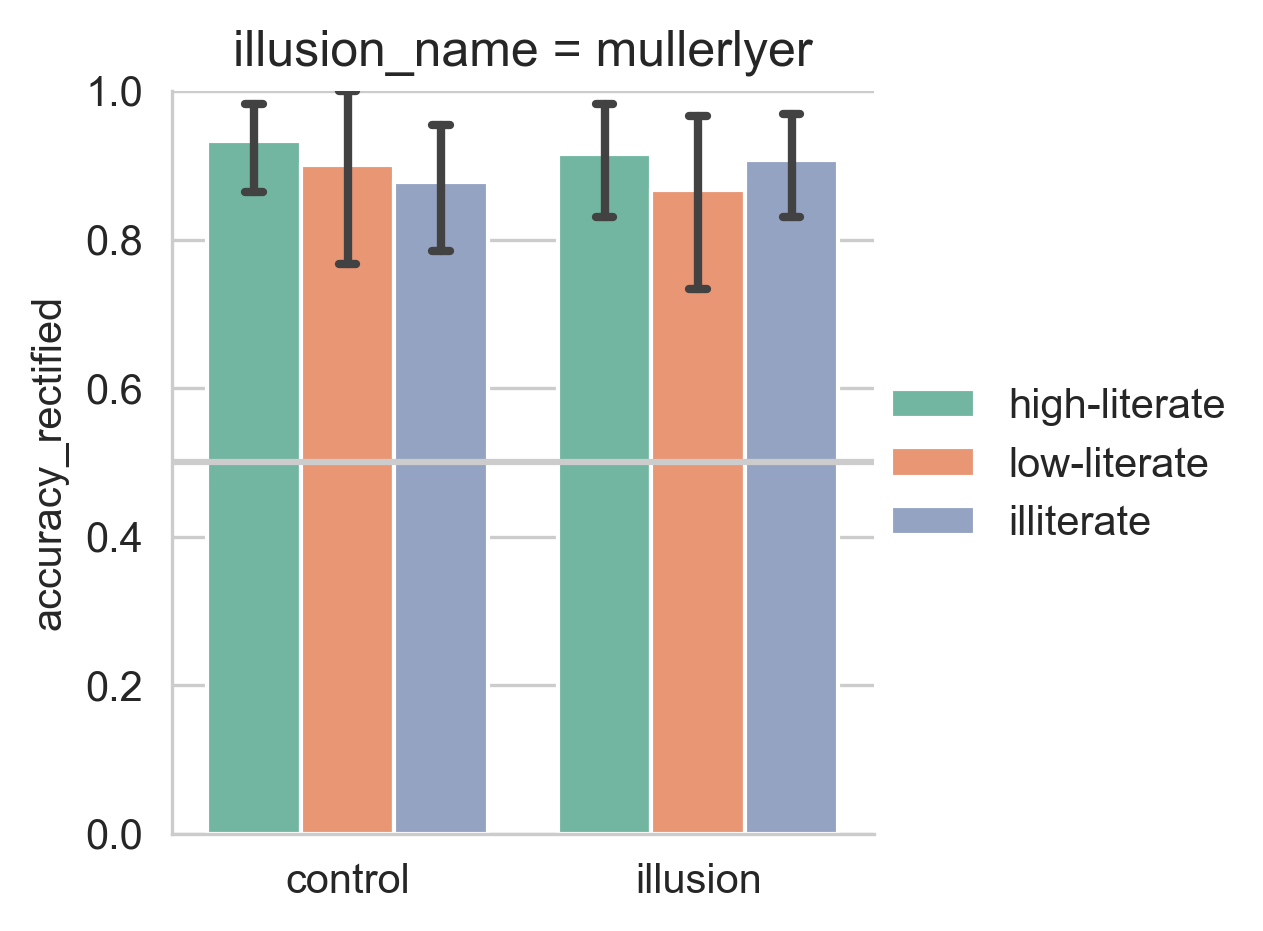

In [30]:
# pooled
g = sns.catplot(
    x='illusion_condition',
    y='accuracy_rectified',
    hue='literate',
    hue_order=['high-literate', 'low-literate', 'illiterate'],
    data=df_pooled[df_pooled['illusion_name'] == 'mullerlyer'].sort_values(
        ['illusion_condition', 'illusion_type']
    ),
    kind='bar',
    height=3,
    capsize=.05,
    errwidth=2
)
g.axes[0][0].axhline(.5, color='.8')
g.legend.set_title('')
g.set(xlabel='', title='illusion_name = mullerlyer', ylim=[0, 1])
plt.savefig('figures/rectified_mullerlyer_barplot_pooled.pdf', bbox_inches='tight')

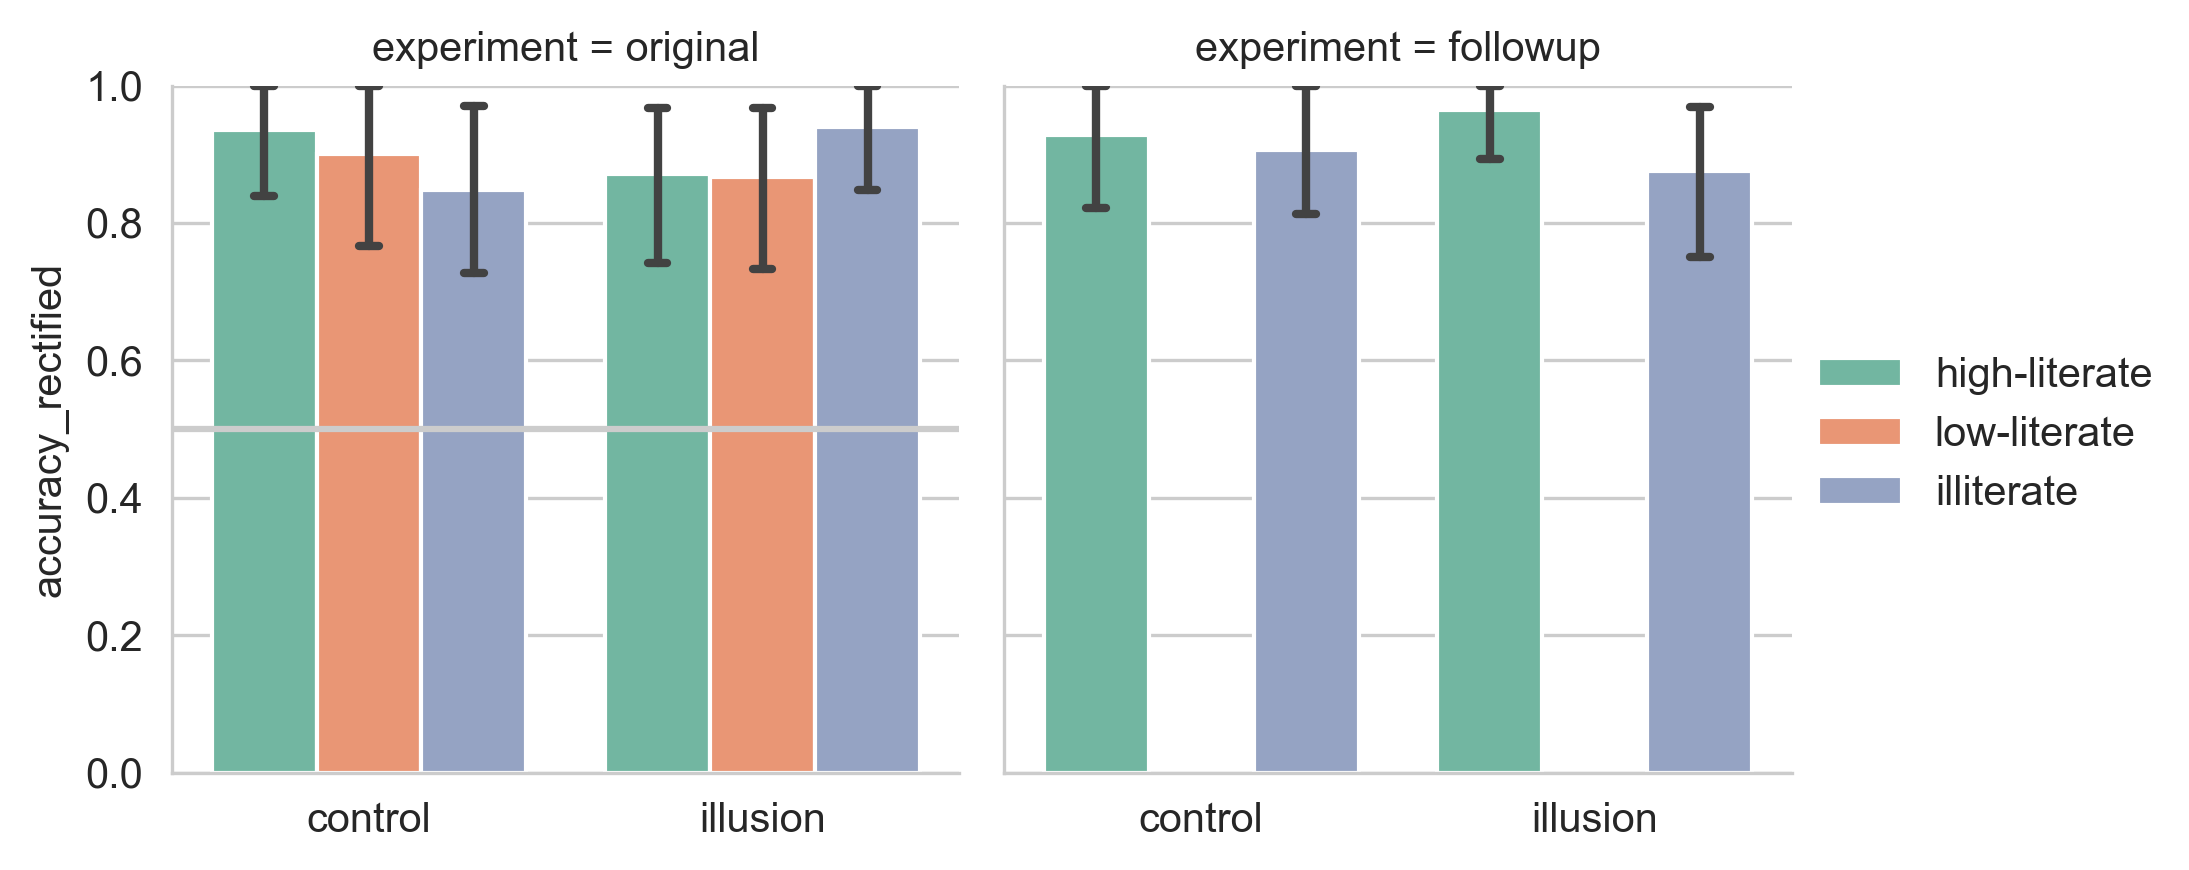

In [35]:
# split
g = sns.catplot(
    x='illusion_condition',
    y='accuracy_rectified',
    hue='literate',
    col='experiment',
    hue_order=['high-literate', 'low-literate', 'illiterate'],
    data=df_pooled[(df_pooled['illusion_name'] == 'mullerlyer')].sort_values(
        ['illusion_condition', 'illusion_type']
    ),
    kind='bar',
    height=3,
    capsize=.05,
    errwidth=2
)
g.axes[0][0].axhline(.5, color='.8')
g.legend.set_title('')
g.set(xlabel='', ylim=[0, 1])
plt.savefig('figures/rectified_mullerlyer_barplot.pdf')

## Creating some centered and standardized predictors

In [ ]:
df = df_pooled

df['reading'] = df['word'] + df['pseudoword']
df['literate_binary'] = df['literate'].apply(lambda x: 1 if x != 'n' else 0)
df['illusion'] = df['illusion_condition'].apply(lambda x: 1 if x == 'illusion' else 0)
df['shape'] = df['illusion_type'].apply(lambda x: 1 if x == 'shape' else 0)

df['reading_z'] = (df['reading'] - df['reading'].mean()) / df['reading'].std()
df['illusion_condition_z'] = df['illusion'] - .5
df['illusion_type_z'] = df['shape'] - .5

df['log_rt'] = np.log(df['RT'])
df['log_rt_z'] = (df['log_rt'] - df['log_rt'].mean()) / df['log_rt'].std()

display(df.round(2))

## Bayesian generalized linear mixed-effects model (GLMM)

In [22]:
model = bambi.Model(df[df['illusion_type'] == 'colour'])
results = model.fit(
    'accuracy_rectified ~ illusion_condition_z * reading_z',
    random=[
        '1 + illusion_condition_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='bernoulli',
    init='advi+adapt_diag',
    chains=3,
    samples=2000,
    tune=2000,
    target_accept=.9,
)

The random argument has been deprecated, please use group_specific
Modeling the probability that accuracy_rectified==1
samples will be deprecated, please use draws instead
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17800
Interrupted at 17,799 [35%]: Average Loss = 700.31
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [reading_z:illusion_condition_z|illusion_name_offset, reading_z:illusion_condition_z|illusion_name_sigma, illusion_condition_z|illusion_name_offset, illusion_condition_z|illusion_name_sigma, reading_z|illusion_name_offset, reading_z|illusion_name_sigma, 1|illusion_name_offset, 1|illusion_name_sigma, illusion_condition_z|participant_offset, illusion_condition_z|participant_sigma, 1|participant_offset, 1|participant_sigma, illusion_condition_z:reading_z, reading_z, illusion_condition_z, Intercept]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 101 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


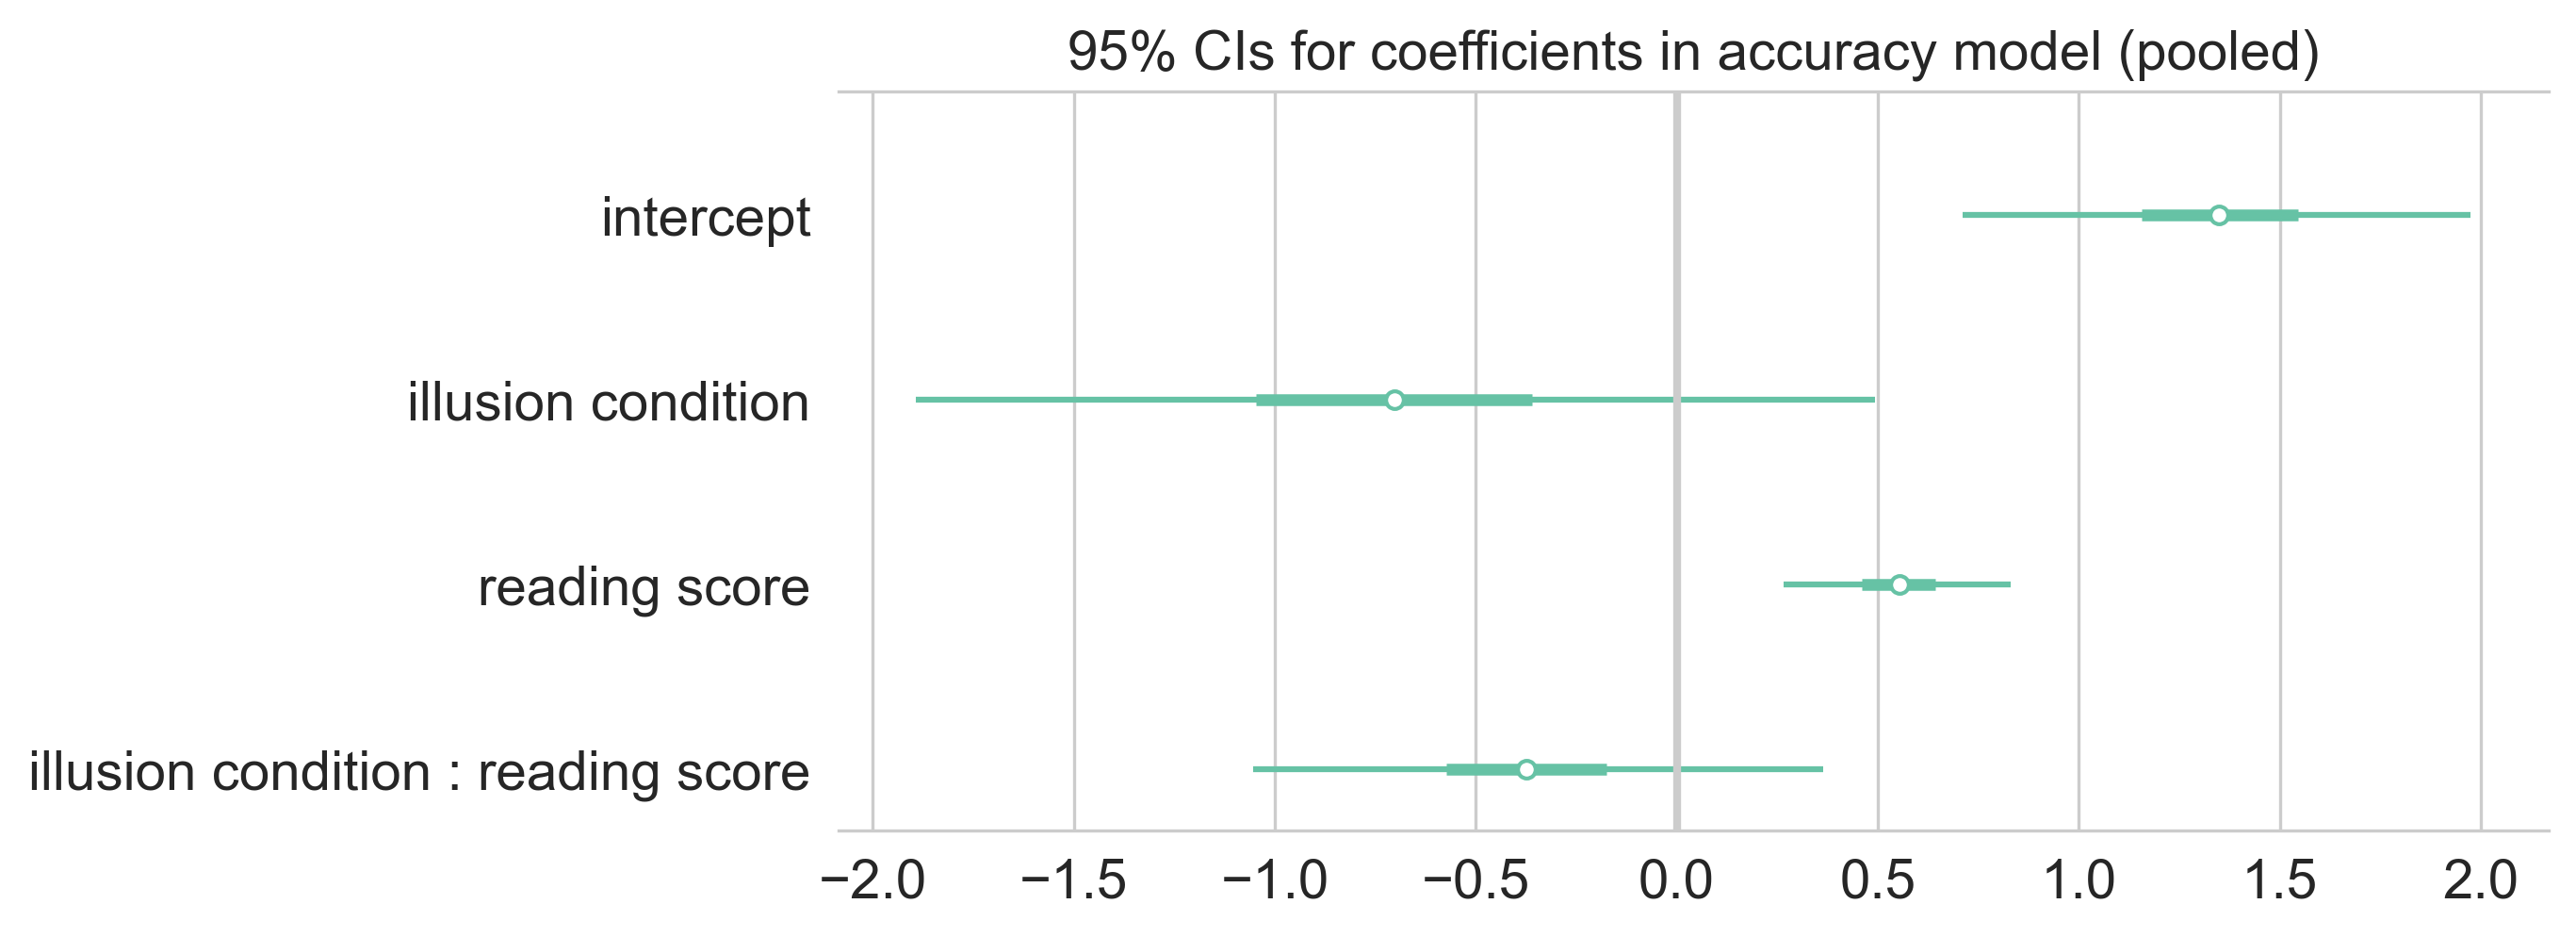

In [23]:
g = az.plot_forest(results, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'reading_z',
                      'illusion_condition_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'reading score',
    'illusion condition : reading score',
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in accuracy model (pooled)', fontsize=14);
plt.savefig('figures/accuracy_forestplot_pooled.pdf')

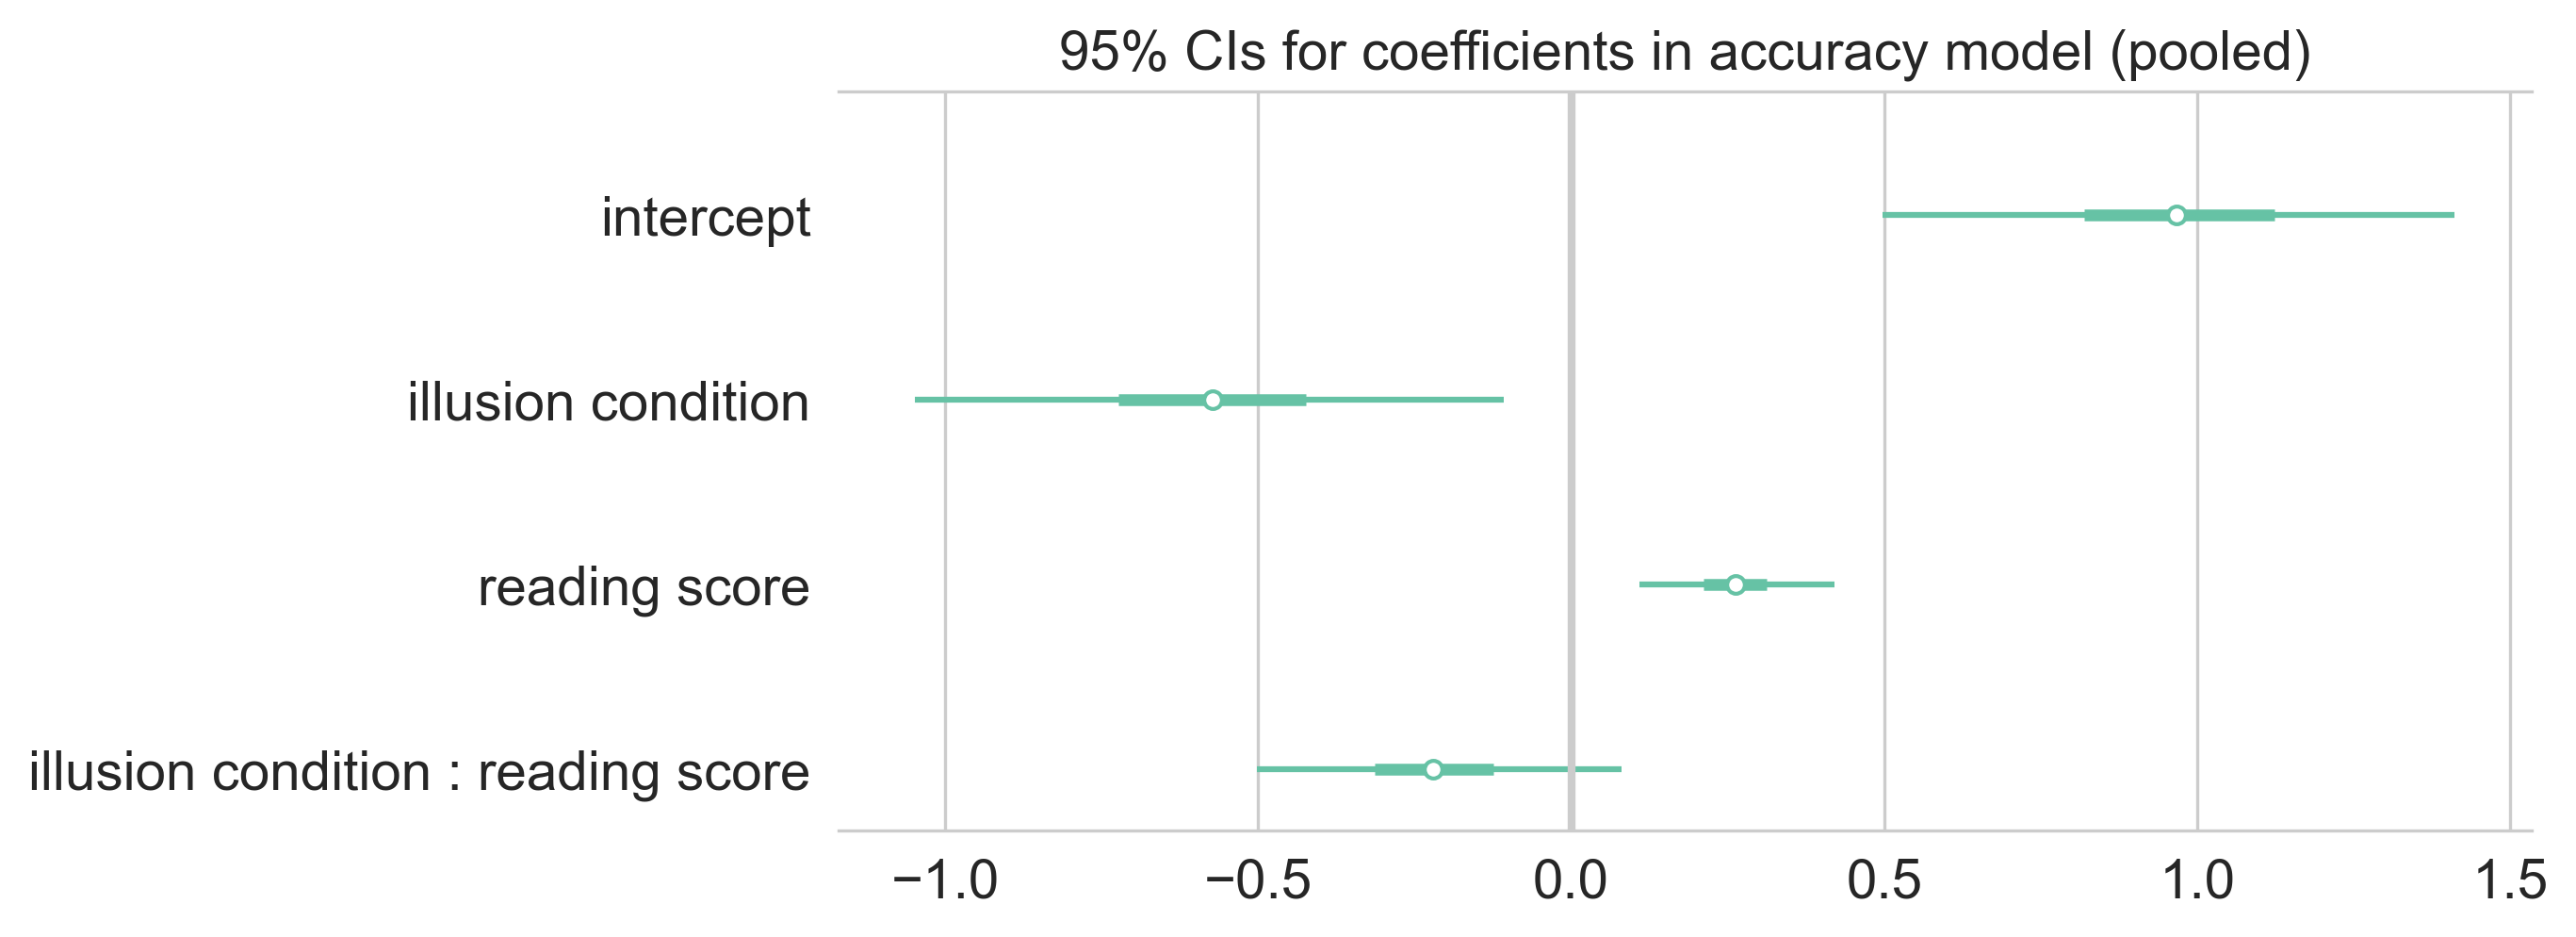

In [21]:
g = az.plot_forest(results, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'reading_z',
                      'illusion_condition_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'reading score',
    'illusion condition : reading score',
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in accuracy model (pooled)', fontsize=14);
plt.savefig('figures/accuracy_forestplot_pooled.pdf')

In [ ]:
model = bambi.Model(df)
results = model.fit(
    'accuracy_rectified ~ illusion_condition_z * illusion_type_z * reading_z',
    group_specific=[
        '1 + illusion_condition_z * illusion_type_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='bernoulli',
    init='advi+adapt_diag',
    chains=3,
    draws=2000,
    tune=2000,
    target_accept=.9,
)

In [ ]:
g = az.plot_forest(results, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'illusion_type_z',
                      'reading_z',
                      'illusion_condition_z:illusion_type_z',
                      'illusion_condition_z:reading_z',
                      'illusion_type_z:reading_z',
                      'illusion_condition_z:illusion_type_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'illusion type',
    'reading score',
    'illusion condition : illusion type',
    'illusion condition : reading score',
    'illusion type : reading score',
    'illusion condition : illusion type : reading score'
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in accuracy model (pooled)', fontsize=14);
plt.savefig('figures/accuracy_forestplot_pooled.pdf')

## Interpreting coefficient estimates
1. `intercept` Positive, so overall participants answer above chance across all trials.
2. `illusion condition` The mean estimate is around -.7, but with a wide compatibility interval. This reflects that illusion questions are generally answered closer to chance than control questions (meaning participants overall perceive illusions, but they are more likely to "not perceive" an illusion than to incorrectly answer a control trial).
3. `illusion type` Mean estimate is close to zero with a wide compatibility interval. Reflects no meaningful difference in base rate correct responses between _shape_ and _color_ trials.
4. `reading score` Mean estimate is not huge, at around .35, but with a very narrow interval, reflecting strong evidence that there is a small positive effect of reading score on the overall chance of answering correctly, as expected.
5. `illusion condition : illusion type` Essentially zero mean estimate and wide interval indicate that the difference between illusion and control trials does not meaningfully differ between _shape_ and _color_ trials.
6. `illusion condition : reading score` This is a **key** coefficient, because it indicates whether reading score affects the difference between illusion and control trials, i.e. that the mean estimate is around -.15 and the interval overlaps with zero indicates that while reading score does improve the overall chance of answering correctly (see 4.) it does **not** improve that chance _specifically_ in the illusion condition.
7. `illusion type : reading score` Reflects that there no meaningful effect (mean effect estimate around -.2, with compatibility interval overlapping zero) of literacy on the difference between _shape_ and _color_ trials.
8. `illusion_z:type_z:reading_z` This three way interaction is estimated at roughly .3, but with large uncertainty. The effect of literacy does not appear to (meaningfully) vary by _both_ illusion versus control and _color_ versus _shape_ illusion conditions.

### Response time model
None of the claims in the prior literature are about the speed with which illiterates perceive (or do not perceive) illusions, so this model mostly serves to confirm (or potentially complicate) the conclusions from our accuracy model.

In [ ]:
model_rt = bambi.Model(df)
results_rt = model_rt.fit(
    'log_rt_z ~ illusion_condition_z * illusion_type_z * reading_z',
    group_specific=[
        '1 + illusion_condition_z * illusion_type_z|participant',
        '1 + reading_z * illusion_condition_z|illusion_name'
    ],
    family='gaussian',
    init='advi+adapt_diag',
    chains=3,
    draws=2000,
    tune=2000,
    target_accept=.9,
)

In [ ]:
g = az.plot_forest(results_rt, combined=True, hdi_prob=.95, figsize=[9, 3.2],
                  var_names=[
                      'Intercept',
                      'illusion_condition_z',
                      'illusion_type_z',
                      'reading_z',
                      'illusion_condition_z:illusion_type_z',
                      'illusion_condition_z:reading_z',
                      'illusion_type_z:reading_z',
                      'illusion_condition_z:illusion_type_z:reading_z',
                  ])
g[0].axvline(0, color='.8', linewidth=2);
labels = [
    'intercept',
    'illusion condition',
    'illusion type',
    'reading score',
    'illusion condition : illusion type',
    'illusion condition : reading score',
    'illusion type : reading score',
    'illusion condition : illusion type : reading score'
]
g[0].set(yticklabels=reversed(labels));
g[0].set_title('95% CIs for coefficients in log(RT) model (pooled)', fontsize=14);
plt.savefig('figures/rt_forestplot_pooled.pdf')

These results are consistent with the estimates from the accuracy model. Illusions take a little longer to recognize than controls, which is unsurprising and consistent with them being answered closer to chance level (see accuracy model). Similarly, higher reading score is associated with slightly shorter RTs overall, which indicates that literates find the task easier to perform (as we concluded from their answering more accurately, per the accuracy model).  

The interactions are all close to zero, as expected given the accuracy model estimates.

# Convert notebook to html

In [ ]:
convert_notebook('illusions')